In [1]:
import pandas as pd
import numpy as np
import keyring
import os, sys
import datetime

from pysnc import ServiceNowClient

import matplotlib.pyplot as plt
from pandas.tools.plotting import table
import matplotlib.cm as cm, matplotlib.font_manager as fm

In [2]:
username = "productsecurity.automation"
password = keyring.get_password("hi.service-now.com", username)

if not password:
    password = password = getpass.getpass()
    keyring.set_password("hi.service-now.com", username, password)
    
def get_df():
    #The URI used to query the records from hi: Active records not opened by qualys that are security PRBs
    #https://hi.service-now.com/problem_list.do?sysparm_query=active%3Dtrue%5Eu_security_incident%3Dtrue%5Eu_problem_type%3DProduct%20Defect&sysparm_first_row=1&sysparm_view=
    
    snc = ServiceNowClient("https://hi.service-now.com", (username, password)) #, proxy='https://127.0.0.1:8080')
    
    gr = snc.GlideRecord("problem")
    gr.add_query("active","true")
    gr.add_query("u_security_incident", "true")
    gr.add_query("u_problem_type","Product Defect")
    #gr.add_query("short_description", "NOT LIKE", "[HI]")
    #gr.add_query("opened_by","!=","8bab01486f68fd008c7ec138eb3ee4d0")
    gr.fields = "number,short_description,u_tags,opened_by"
    gr.query()
    data, col = gr.to_pandas()
    problem_df = pd.DataFrame.from_records(data, columns=col)
    return problem_df

In [3]:
problem_df= get_df()
problem_df.head(10)

sys_class_name number__value number__display  \
0        problem    PRB1007438      PRB1007438   
1        problem    PRB1028635      PRB1028635   
2        problem    PRB1031382      PRB1031382   
3        problem    PRB1078808      PRB1078808   
4        problem    PRB1086787      PRB1086787   
5        problem    PRB1088315      PRB1088315   
6        problem    PRB1090087      PRB1090087   
7        problem    PRB1090091      PRB1090091   
8        problem    PRB1105243      PRB1105243   
9        problem    PRB1150458      PRB1150458   

                            short_description__value  \
0  [Security Bug] Cross scope sandbox not using G...   
1           [Security Bug] Reflected XSS via list v3   
2  [Security Bug] Service Catalog API: External u...   
3  [Security Bug] Unrestricted access to add atta...   
4  [Security Bug] Database passwords stored in gl...   
5  [Security Bug] Angular Filter Builder: HTML In...   
6  Service Portal - [Security Bug] Library out of...   
7  [Security Bug] Library out of Date - Moment.js...   
8  [Security Bug][Devportal] General users can us...   
9  [Security Bug] [App Store] /appStore.do: Many ...   

                          short_description__display  \
0  [Security Bug] Cross scope sandbox not using G...   
1           [Security Bug] Reflected XSS via list v3   
2  [Security Bug] Service Catalog API: External u...   
3  [Security Bug] Unrestricted access to add atta...   
4  [Security Bug] Database passwords stored in gl...   
5  [Security Bug] Angular Filter Builder: HTML In...   
6  Service Portal - [Security Bug] Library out of...   
7  [Security Bug] Library out of Date - Moment.js...   
8  [Security Bug][Devportal] General users can us...   
9  [Security Bug] [App Store] /appStore.do: Many ...   

                                       u_tags__value  \
0  Security Bug, PC-Backport Approved-GP8, PC-Bac...   
1  Security Bug, catalogEscaping, Sheddy Committe...   
2  Security Bug, PC-Backport Approved-GP8, Remove...   
3  Security Bug, ACL, London-SecurityMust, Commun...   
4   Security Bug, Information Disclosure, PRB1079887   
5                   Security Bug, App, XSS, Escaping   
6  Security Bug, Customer-Reported, Insecure Library   
7  Security Bug, Customer-Reported, Insecure Libr...   
8             Security Bug, App, Cobalt, Bounty, ACL   
9          Security Bug, ACL, AppSec-HVI, AppSec-Ext   

                                     u_tags__display  \
0  Security Bug, PC-Backport Approved-GP8, PC-Bac...   
1  Security Bug, catalogEscaping, Sheddy Committe...   
2  Security Bug, PC-Backport Approved-GP8, Remove...   
3  Security Bug, ACL, London-SecurityMust, Commun...   
4   Security Bug, Information Disclosure, PRB1079887   
5                   Security Bug, App, XSS, Escaping   
6  Security Bug, Customer-Reported, Insecure Library   
7  Security Bug, Customer-Reported, Insecure Libr...   
8             Security Bug, App, Cobalt, Bounty, ACL   
9          Security Bug, ACL, AppSec-HVI, AppSec-Ext   

                   opened_by__value       opened_by__display  
0  6687a32bd5703d80c602d97466d5a601     Ismail Aydemir (NOW)  
1  6687a32bd5703d80c602d97466d5a601     Ismail Aydemir (NOW)  
2  88c817186f914a407b658e4c2c3ee4c2        Pavan Mohan (NOW)  
3  742fa03fdb9aaa008c8ef4621f961931  Partha Srinivasan (NOW)  
4  3e163106db87be40fb4bf85e0f961925    Vaibhav Agrawal (NOW)  
5  88c817186f914a407b658e4c2c3ee4c2        Pavan Mohan (NOW)  
6  99b87b55db8caa00fb4bf85e0f961950       Matthew Gill (NOW)  
7  99b87b55db8caa00fb4bf85e0f961950       Matthew Gill (NOW)  
8  9db266c3db6fbac4b013f47e0f961973      Justin Meeken (NOW)  
9  d1e5098fdb023680e9737a9e0f96191d     Paul Marrapese (NOW)

In [4]:
# Best system of record for tags is here:
# https://securitynow.service-now.com/x_snc_psdash_remediation_template_table_list.do
#

category_tags=['ACL', 
'Authentication Bypass', 
'CSRF', 
'Crypto Security', 
'Dangerous APIs', 
'Denial of service', 
'Domain Separation', 
'Escaping', 
'Information Disclosure', 
'Insecure Default Credential', 
'Insecure Library', 
'JavaScript Sandbox', 
'JavaScript Whitelist', 
'Jelly/Jexl', 
'Open Redirect', 
'Privilege Escalation', 
'SQL Injection',
'Security Properties Config', 
'Session Management',
'XSS' ]

tag_list=[]


# Fix legacy manual tagging formatting inconsistencies
def cleanup_tag(x):
    cont = True
    
    while(cont):
        cont = False
        if x.startswith(" "):
            x = x[1:]
            cont = True
        if x.endswith(" "):
            x = x[:-1]
            cont = True
    return x

# Legacy core platform tagging scheme
def strip_cp(x):
    if x.startswith("CP - "):
        x = x[5:]
    return x

def flag_cat(x):
    tags = x['u_tags__display']
    num = x['number__display']
    sd = x['short_description__display']
    ob = x['opened_by__display']
    
    if type(tags) is not str:
        pass
    else:
        tags = tags.split(",")
        tag_set = False
        cp_tag_set = False
        first_found_cat = ''
        for tag in tags:
            
            # Handle some  user input errors from legacy tagging mechanisms
            tag = cleanup_tag(tag)
            
            if tag.startswith("CP - "):
                tag = strip_cp(tag)
                cp_tag_set = True
            
            if (tag == 'Escaping'):
                continue
                    
            if tag in category_tags:
                first_found_cat = tag
                tag_set = True
        
        if not (tag_set or cp_tag_set):
            
            print("No Category Tag Found for {0}".format(num))
            print("Tag set: {0}, CP Tag Set: {1}".format(tag_set,cp_tag_set))
            print("Tags: {0}".format(tags))
            print("SD: {0}".format(sd))
            print("Opened By: {0}".format(ob))
            print()
            return "None"
        else:
            return first_found_cat

In [5]:
problem_df.shape[0]

133

In [6]:
problem_df['Category'] = problem_df.apply(flag_cat, axis=1)

No Category Tag Found for PRB1242651
Tag set: False, CP Tag Set: False
Tags: ['Security Bug', ' CX', ' HVI']
SD: [Security Bug] [AppStore]: Unauthenticated access to demo instance details
Opened By: Pavan Mohan (NOW)

No Category Tag Found for PRB1250694
Tag set: False, CP Tag Set: False
Tags: ['Security Bug', ' Casaba-PRDI', ' PRDI', ' casaba']
SD: [Security Bug] Consider digitally signing third-party components included in the installation | Password Reset Application
Opened By: Pavan Mohan (NOW)

No Category Tag Found for PRB1268048
Tag set: False, CP Tag Set: False
Tags: ['Security Bug']
SD: Vulnerability for DoS through publicly accessible attachments
Opened By: Alex North (NOW)

No Category Tag Found for PRB1269270
Tag set: False, CP Tag Set: False
Tags: ['Security Bug', ' App', ' IDC_AuthN']
SD: [Security Bug] Authentication of users with "Password needs reset" flag
Opened By: Pavan Mohan (NOW)

No Category Tag Found for PRB1269398
Tag set: False, CP Tag Set: False
Tags: ['Secur

In [ ]:
tags_df.head(10)

In [11]:
all_tags = problem_df['Category'].value_counts().sort_values(ascending=False)

In [12]:
title_font = fm.FontProperties(family='Arial', style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family='Arial', style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family='Arial', style='normal', size=16, weight='normal', stretch='normal')
annotation_font = fm.FontProperties(family='Arial', style='normal', size=11, weight='normal', stretch='normal')

def gbplot_pie(fractions, #values for the wedges
    labels, #labels for the wedges
    title = '', #title of the pie chart
    cm_name = 'Paired', #name of the matplotlib colormap to use
    autopct = '%1.1f%%', #format the value text on each pie wedge
    labeldistance = 1.05, #where to place wedge labels in relation to pie wedges
    shadow = True, #shadow around the pie
    startangle = 90, #rotate 90 degrees to start the top of the data set on the top of the pie
    edgecolor = 'w', #color of pie wedge edges
    width = 8, #width of the figure in inches
    height = 8, #height of the figure in inches
    grouping_threshold = None, #group all wedges below this value into one 'all others' wedge
    grouping_label = None): #what the label the grouped wedge
  
    # if the user passed a threshold value, group all fractions lower than it into one 'misc' pie wedge
    if not grouping_threshold==None:
        
        # if user didn't pass a label, apply a default text
        if grouping_label == None:
            grouping_label = 'Others'

        # select the rows greater than the cutoff value
        row_mask = fractions > grouping_threshold
        meets_threshold = fractions[row_mask]

        # group all other rows below the cutoff value
        all_others = pd.Series(fractions[~row_mask].sum())
        all_others.index = [grouping_label]

        # append the grouped row to the bottom of the rows to display
        fractions = meets_threshold.append(all_others)
        labels = fractions.index
    
    # get the color map then pull 1 color from it for each pie wedge we'll draw
    color_map = cm.get_cmap(cm_name)
    num_of_colors = len(fractions)
    colors = color_map([x/float(num_of_colors) for x in range(num_of_colors)])
    
    # create the figure and an axis to plot on
    fig, ax = plt.subplots(figsize=[width, height])
    
    # plot the pie
    wedges = ax.pie(fractions, 
                    labels = labels, 
                    labeldistance = labeldistance,
                    autopct = autopct,
                    colors = colors,
                    shadow = shadow, 
                    startangle = startangle)
    
    # change the edgecolor for each wedge
    for wedge in wedges[0]:
        wedge.set_edgecolor(edgecolor)
    
    # set the title and show the plot
    ax.set_title(title, fontproperties=title_font)
    plt.show()

def my_autopct(pct):
    total = sum(all_tags)
    val = int(round(pct*total)/100.0000)
    return '{v:d}'.format(v=val)

gbplot_pie(fractions = all_tags,
           labels = all_tags.index,
           title = '',
           autopct=my_autopct,
           grouping_threshold = 3,
           grouping_label = "All Other Tags")

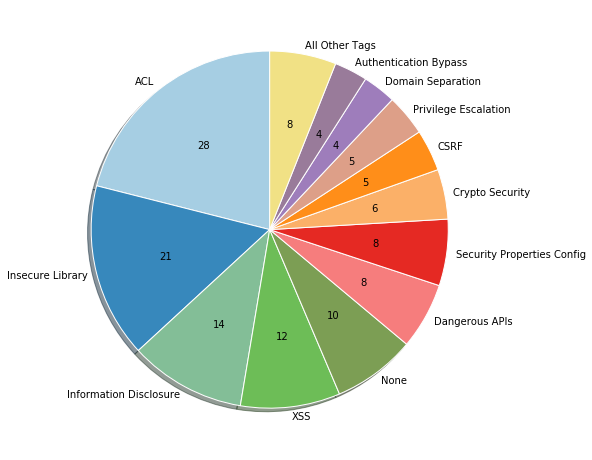

In [13]:
gbplot_pie(fractions = all_tags,
           labels = all_tags.index,
           title = '',
           autopct=my_autopct,
           grouping_threshold = 3,
           grouping_label = 'All Other Tags')